<a href="https://colab.research.google.com/github/Prajwalsrinvas/advent_of_haystack_2024/blob/main/Advent_of_Haystack_Day_1_Enhancing_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advent of Haystack: Day 1


In this first challenge, we are going to build a pipeline that answers questions based on the contents of a URL. The given pipeline works as is, but your task is to complete the connnections and add the **other required two components**👇

**You should complete the missing sections in step 3, 4 and 5**

### Initial Components to use:
- [`LinkContentFetcher`](https://docs.haystack.deepset.ai/docs/linkcontentfetcher) for using the contents of several URLs in your pipeline
- [`HTMLToDocument`](https://docs.haystack.deepset.ai/docs/htmltodocument) for converting the HTML files into documents.
- [`PromptBuilder`](https://docs.haystack.deepset.ai/docs/promptbuilder) for creating the prompt
- [`OpenAIGenerator`](https://docs.haystack.deepset.ai/docs/openaigenerator) for generating responses

https://docs.haystack.deepset.ai/docs/documentsplitter  
https://docs.haystack.deepset.ai/docs/cohereranker

### 1) Installation

Install `haystack-ai`, `trafilatura` and `sentence-transformers` packages with `pip`:

In [1]:
!pip install -q haystack-ai cohere-haystack trafilatura "sentence-transformers>=3.0.0"
!pip install -q --upgrade openai # not to get the OpenAI proxies error: https://community.openai.com/t/error-with-openai-1-56-0-client-init-got-an-unexpected-keyword-argument-proxies/1040332/2

### (Optional) Change the Logging Level

This way, not only warnings but also information messages are displayed in the console output.

In [2]:
import logging

logging.basicConfig(format="%(levelname)s - %(name)s -  %(message)s", level=logging.WARNING)
logging.getLogger("haystack").setLevel(logging.DEBUG)

### 2) Enter API key for OpenAI
If you will use OpenAI models, save your API key as `OPENAI_API_KEY` environment variable.

In [3]:
from getpass import getpass
import os

os.environ["OPENAI_API_KEY"] = getpass("Enter OpenAI API key:")
os.environ["COHERE_API_KEY"] = getpass("Enter Cohere API key:")

Enter OpenAI API key:··········
Enter Cohere API key:··········


### 3) Create components

Initialize two components to complete the pipeline.

**Hints**:
* One component is to split the documents into smaller chunks of 10 sentences each.
* As the other component, consider methods or components you can use to filter out irrelevant chunks by ranking before injecting the context into the prompt

In [4]:
from haystack.components.fetchers import LinkContentFetcher
from haystack.components.converters import HTMLToDocument
from haystack.components.builders import PromptBuilder
from haystack.components.generators import OpenAIGenerator
from haystack.components.preprocessors import DocumentSplitter
from haystack_integrations.components.rankers.cohere import CohereRanker


fetcher = LinkContentFetcher()
converter = HTMLToDocument()
splitter = DocumentSplitter(split_by="sentence", split_length=10, split_overlap=0)
ranker = CohereRanker()
template = """Given the information below, answer the query. Only use the provided context to generate the answer and output the used document links
            Context:
            {% for document in documents %}
                {{ document.content }}
                URL: {{ document.meta.url }}
            {% endfor %}

            Question: {{ query }}
            Answer:"""

prompt_builder = PromptBuilder(template = template)
generator = OpenAIGenerator(model="gpt-4o-mini")

DEBUG:haystack.core.component.component:Registering <class 'haystack.components.fetchers.link_content.LinkContentFetcher'> as a component
DEBUG:haystack.core.component.component:Registered Component <class 'haystack.components.fetchers.link_content.LinkContentFetcher'>
DEBUG:haystack.core.component.component:Registering <class 'haystack.components.converters.azure.AzureOCRDocumentConverter'> as a component
DEBUG:haystack.core.component.component:Registered Component <class 'haystack.components.converters.azure.AzureOCRDocumentConverter'>
DEBUG:haystack.core.component.component:Registering <class 'haystack.components.converters.csv.CSVToDocument'> as a component
DEBUG:haystack.core.component.component:Registered Component <class 'haystack.components.converters.csv.CSVToDocument'>
DEBUG:haystack.core.component.component:Registering <class 'haystack.components.converters.docx.DOCXToDocument'> as a component
DEBUG:haystack.core.component.component:Registered Component <class 'haystack.comp

### 4) Add them to a Haystack Pipeline

In [5]:
from haystack import Pipeline

pipeline = Pipeline()
pipeline.add_component(name="fetcher", instance=fetcher)
pipeline.add_component(name="converter", instance=converter)

pipeline.add_component(name='splitter',instance=splitter)
pipeline.add_component(name='ranker',instance=ranker)

pipeline.add_component(name="prompt_builder", instance=prompt_builder)
pipeline.add_component(name="generator", instance=generator)

DEBUG:haystack.core.pipeline.base:Adding component 'fetcher' (<haystack.components.fetchers.link_content.LinkContentFetcher object at 0x7c306b3a79a0>

Inputs:
  - urls: List[str]
Outputs:
  - streams: List[ByteStream])
DEBUG:haystack.core.pipeline.base:Adding component 'converter' (<haystack.components.converters.html.HTMLToDocument object at 0x7c3191975c30>

Inputs:
  - sources: List[Union[str, Path, ByteStream]]
  - meta: Union[Dict[str, Any], List[Dict[str, Any]]]
  - extraction_kwargs: Optional[Dict[str, Any]]
Outputs:
  - documents: List[Document])
DEBUG:haystack.core.pipeline.base:Adding component 'splitter' (<haystack.components.preprocessors.document_splitter.DocumentSplitter object at 0x7c306af337c0>

Inputs:
  - documents: List[Document]
Outputs:
  - documents: List[Document])
DEBUG:haystack.core.pipeline.base:Adding component 'ranker' (<haystack_integrations.components.rankers.cohere.ranker.CohereRanker object at 0x7c306af33a30>

Inputs:
  - query: str
  - documents: List[Do

###5) Connect the components

Complete the pipeline connections to achieve a working pipeline that can be run.

**Note:** Everytime you want to run cell 4 and cell 5, you need to run cell 3 and reinitialize all components

In [6]:
pipeline.connect("fetcher.streams", "converter.sources")
pipeline.connect("converter.documents", "splitter.documents")
pipeline.connect("splitter.documents", "ranker.documents")
pipeline.connect("ranker.documents", "prompt_builder.documents")
pipeline.connect("prompt_builder", "generator")

DEBUG:haystack.core.pipeline.base:Connecting 'fetcher.streams' to 'converter.sources'
DEBUG:haystack.core.pipeline.base:Connecting 'converter.documents' to 'splitter.documents'
DEBUG:haystack.core.pipeline.base:Connecting 'splitter.documents' to 'ranker.documents'
DEBUG:haystack.core.pipeline.base:Connecting 'ranker.documents' to 'prompt_builder.documents'
DEBUG:haystack.core.pipeline.base:Connecting 'prompt_builder.prompt' to 'generator.prompt'


🚅 Components
  - fetcher: LinkContentFetcher
  - converter: HTMLToDocument
  - splitter: DocumentSplitter
  - ranker: CohereRanker
  - prompt_builder: PromptBuilder
  - generator: OpenAIGenerator
🛤️ Connections
  - fetcher.streams -> converter.sources (List[ByteStream])
  - converter.documents -> splitter.documents (List[Document])
  - splitter.documents -> ranker.documents (List[Document])
  - ranker.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> generator.prompt (str)

###6) Visualize the Pipeline 🎨

Display the pipeline image with [`show()`](https://docs.haystack.deepset.ai/docs/visualizing-pipelines) method to understand the connections between components

DEBUG:haystack.core.pipeline.draw:Mermaid diagram:

%%{ init: {'theme': 'neutral' } }%%

graph TD;

fetcher["<b>fetcher</b><br><small><i>LinkContentFetcher</i></small>"]:::component -- "streams -> sources<br><small><i>List[ByteStream]</i></small>" --> converter["<b>converter</b><br><small><i>HTMLToDocument<br><br>Optional inputs:<ul style='text-align:left;'><li>meta (Union[Dict[str, Any], List[Dict[str, Any]]])</li><li>extraction_kwargs (Optional[Dict[str, Any]])</li></ul></i></small>"]:::component
converter["<b>converter</b><br><small><i>HTMLToDocument<br><br>Optional inputs:<ul style='text-align:left;'><li>meta (Union[Dict[str, Any], List[Dict[str, Any]]])</li><li>extraction_kwargs (Optional[Dict[str, Any]])</li></ul></i></small>"]:::component -- "documents -> documents<br><small><i>List[Document]</i></small>" --> splitter["<b>splitter</b><br><small><i>DocumentSplitter</i></small>"]:::component
splitter["<b>splitter</b><br><small><i>DocumentSplitter</i></small>"]:::component -- "docu

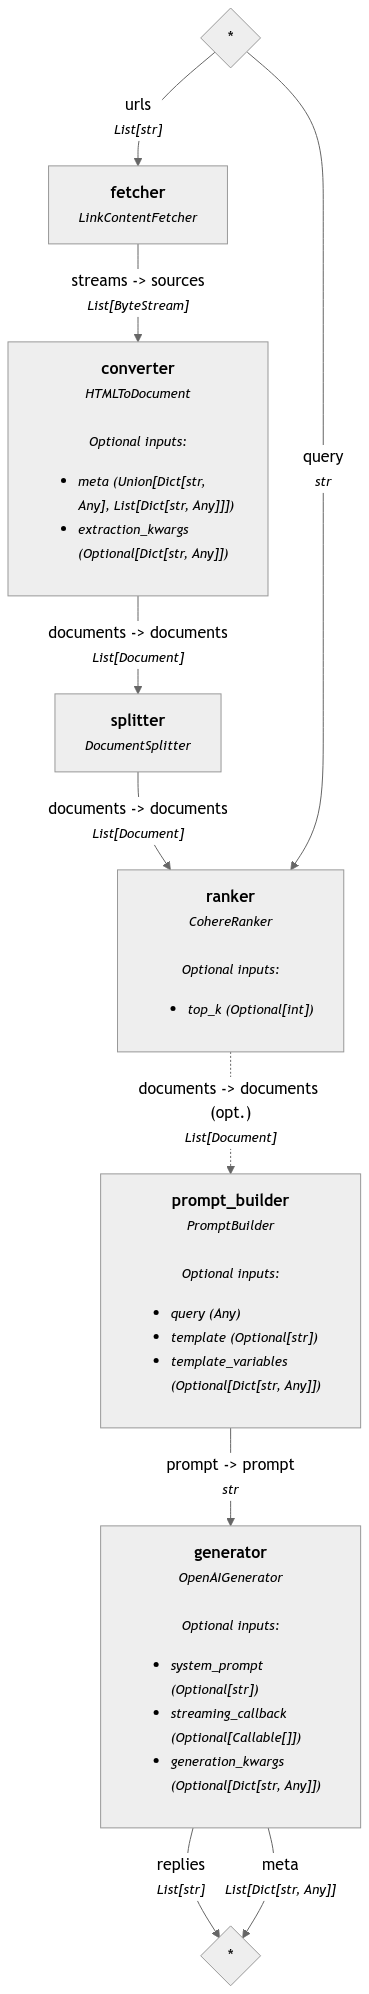

In [7]:
pipeline.show()

###7) Run the Pipeline

Use the URLs below and try the example queries.

In [8]:
urls = ["https://haystack.deepset.ai/blog/extracting-metadata-filter",
        "https://haystack.deepset.ai/blog/query-expansion",
        "https://haystack.deepset.ai/blog/query-decomposition",
        "https://haystack.deepset.ai/cookbook/metadata_enrichment"]

queries = ["What is the difference between metadata filtering and metadata enrichment?",
"Which methods can I use to transform query for better retrieval?",
"How can I use metadata to improve retrieval?",
"What's preprocessing?"] # Should return no answer

## Add parameters
for query in queries:
  result = pipeline.run(data={"fetcher": {"urls": urls}, "ranker": {"query": query, "top_k": 2},"prompt_builder": {"query": query}})
  print(f'\n\n{query=}')
  # Print the LLM response
  print(result['generator']['replies'][0])
  print('-'*100)

INFO:haystack.core.pipeline.pipeline:Running component fetcher
INFO:haystack.core.pipeline.pipeline:Running component converter
INFO:haystack.core.pipeline.pipeline:Running component splitter
INFO:haystack.core.pipeline.pipeline:Running component ranker
INFO:haystack.core.pipeline.pipeline:Running component prompt_builder
INFO:haystack.core.pipeline.pipeline:Running component generator
INFO:haystack.core.pipeline.pipeline:Running component fetcher
INFO:haystack.core.pipeline.pipeline:Running component converter




query='What is the difference between metadata filtering and metadata enrichment?'
Metadata filtering is a process of applying filters to queries that limit the scope of search results based on existing metadata attributes, such as date, topic, or source. It helps in retrieving documents that match specific metadata criteria, ensuring that the results are relevant to the user's query.

On the other hand, metadata enrichment involves the process of automatically enhancing the metadata of documents by extracting new information and adding custom attributes. This is done using a Pydantic Model to define metadata fields and using a custom component to populate these fields with relevant data, thus improving the quality and usability of the metadata.

In summary, while metadata filtering focuses on retrieving documents based on predefined metadata characteristics, metadata enrichment is about adding new and structured metadata to improve document categorization and retrieval.

Used docume

INFO:haystack.core.pipeline.pipeline:Running component splitter
INFO:haystack.core.pipeline.pipeline:Running component ranker
INFO:haystack.core.pipeline.pipeline:Running component prompt_builder
INFO:haystack.core.pipeline.pipeline:Running component generator
INFO:haystack.core.pipeline.pipeline:Running component fetcher
INFO:haystack.core.pipeline.pipeline:Running component converter




query='Which methods can I use to transform query for better retrieval?'
To transform queries for better retrieval, you can use methods such as:

1. **Query Decomposition**: This method breaks down a complex question into smaller, independent sub-questions. By answering these sub-questions individually, you can reason about the final answer, which enhances the retrieval process.

2. **Query Expansion**: This method involves expanding keyword queries to improve recall and provide more context for the retrieval process. It helps in increasing the number of results, thereby improving the chances of retrieving relevant information.

These techniques can significantly enhance the effectiveness of retrieval augmented generation (RAG) systems.

**Used Document Links:**
- https://haystack.deepset.ai/blog/query-decomposition
- https://haystack.deepset.ai/blog/query-expansion
----------------------------------------------------------------------------------------------------


INFO:haystack.core.pipeline.pipeline:Running component splitter
INFO:haystack.core.pipeline.pipeline:Running component ranker
INFO:haystack.core.pipeline.pipeline:Running component prompt_builder
INFO:haystack.core.pipeline.pipeline:Running component generator
INFO:haystack.core.pipeline.pipeline:Running component fetcher
INFO:haystack.core.pipeline.pipeline:Running component converter




query='How can I use metadata to improve retrieval?'
You can use metadata to improve retrieval by implementing metadata filtering in your Retrieval-Augmented Generation (RAG) applications. Metadata allows you to categorize, sort, and filter information based on attributes like date, topic, source, or other relevant information. By applying metadata filters to your queries, you can limit the search space and ensure that the retrieved documents align well with the specific query or topic, enhancing relevance and accuracy. This leads to improved efficiency in processing and retrieval response times.

For example, if you filter based on metadata such as the year and company, you can ensure that only relevant documents are returned for queries about revenue increases. This enhances the quality of the generated responses by providing precise context.

Used document links:
- https://haystack.deepset.ai/blog/extracting-metadata-filter
---------------------------------------------------------

INFO:haystack.core.pipeline.pipeline:Running component splitter
INFO:haystack.core.pipeline.pipeline:Running component ranker
INFO:haystack.core.pipeline.pipeline:Running component prompt_builder
INFO:haystack.core.pipeline.pipeline:Running component generator




query="What's preprocessing?"
Preprocessing in the context of LLM-based applications refers to the process of extracting metadata filters from a natural language query before using it with a retriever. This involves identifying valuable hints in the query that can improve retrieval accuracy, such as identifying specific years or companies mentioned. For example, in the query "What was the revenue of Nvidia in 2022?", the year "2022" and the company "Nvidia" can be extracted and formulated into structured metadata filters to enhance the information retrieval process.

Used Document Links:
1. https://haystack.deepset.ai/blog/extracting-metadata-filter
2. https://haystack.deepset.ai/blog/query-decomposition
----------------------------------------------------------------------------------------------------


### (Optional) Bonus Task

Try to recreate the same pipeline but this time, use [OpenAIChatGenerator](https://docs.haystack.deepset.ai/docs/openaichatgenerator) and [ChatPromptBuilder](https://docs.haystack.deepset.ai/docs/chatpromptbuilder)

In [9]:
from haystack.components.fetchers import LinkContentFetcher
from haystack.components.converters import HTMLToDocument
from haystack.components.generators.chat import OpenAIChatGenerator
from haystack.components.builders import ChatPromptBuilder
from haystack.dataclasses import ChatMessage
from haystack.components.preprocessors import DocumentSplitter
from haystack_integrations.components.rankers.cohere import CohereRanker


fetcher = LinkContentFetcher()
converter = HTMLToDocument()
splitter = DocumentSplitter(split_by="sentence", split_length=10, split_overlap=0)
ranker = CohereRanker()
template = """Given the information below, answer the query. Only use the provided context to generate the answer and output the used document links
            Context:
            {% for document in documents %}
                {{ document.content }}
                URL: {{ document.meta.url }}
            {% endfor %}

            Question: {{ query }}
            Answer:"""


system_message = """You are a technical expert. Use only the provided content and source URLs to answer questions. Don't use your own knowledge.
Do not add any extra information or search the web.
Keep your answers clear, accurate, and to the point, including the document links you used.
If the documents don’t have the answer, say "no answer"
"""

system_message = ChatMessage.from_system(system_message)
messages = [system_message, ChatMessage.from_user(template)] # being used in pipeline.run


pipeline = Pipeline()
pipeline.add_component(name="fetcher", instance=fetcher)
pipeline.add_component(name="converter", instance=converter)

pipeline.add_component(name='splitter',instance=splitter)
pipeline.add_component(name='ranker',instance=ranker)

pipeline.add_component(name="prompt_builder", instance=ChatPromptBuilder(variables=["query", "documents"]))
pipeline.add_component(name="generator", instance=OpenAIChatGenerator(model="gpt-4o-mini"))

pipeline.connect("fetcher.streams", "converter.sources")
pipeline.connect("converter.documents", "splitter.documents")
pipeline.connect("splitter.documents", "ranker.documents")
pipeline.connect("ranker.documents", "prompt_builder")
pipeline.connect("prompt_builder", "generator")

DEBUG:haystack.core.component.component:Registering <class 'haystack.components.generators.chat.openai.OpenAIChatGenerator'> as a component
DEBUG:haystack.core.component.component:Registered Component <class 'haystack.components.generators.chat.openai.OpenAIChatGenerator'>
DEBUG:haystack.core.component.component:Registering <class 'haystack.components.generators.chat.azure.AzureOpenAIChatGenerator'> as a component
DEBUG:haystack.core.component.component:Registered Component <class 'haystack.components.generators.chat.azure.AzureOpenAIChatGenerator'>
DEBUG:haystack.core.component.component:Registering <class 'haystack.components.generators.chat.hugging_face_local.HuggingFaceLocalChatGenerator'> as a component
DEBUG:haystack.core.component.component:Registered Component <class 'haystack.components.generators.chat.hugging_face_local.HuggingFaceLocalChatGenerator'>
DEBUG:haystack.core.component.component:Registering <class 'haystack.components.generators.chat.hugging_face_api.HuggingFaceAP

🚅 Components
  - fetcher: LinkContentFetcher
  - converter: HTMLToDocument
  - splitter: DocumentSplitter
  - ranker: CohereRanker
  - prompt_builder: ChatPromptBuilder
  - generator: OpenAIChatGenerator
🛤️ Connections
  - fetcher.streams -> converter.sources (List[ByteStream])
  - converter.documents -> splitter.documents (List[Document])
  - splitter.documents -> ranker.documents (List[Document])
  - ranker.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> generator.messages (List[ChatMessage])

DEBUG:haystack.core.pipeline.draw:Mermaid diagram:

%%{ init: {'theme': 'neutral' } }%%

graph TD;

fetcher["<b>fetcher</b><br><small><i>LinkContentFetcher</i></small>"]:::component -- "streams -> sources<br><small><i>List[ByteStream]</i></small>" --> converter["<b>converter</b><br><small><i>HTMLToDocument<br><br>Optional inputs:<ul style='text-align:left;'><li>meta (Union[Dict[str, Any], List[Dict[str, Any]]])</li><li>extraction_kwargs (Optional[Dict[str, Any]])</li></ul></i></small>"]:::component
converter["<b>converter</b><br><small><i>HTMLToDocument<br><br>Optional inputs:<ul style='text-align:left;'><li>meta (Union[Dict[str, Any], List[Dict[str, Any]]])</li><li>extraction_kwargs (Optional[Dict[str, Any]])</li></ul></i></small>"]:::component -- "documents -> documents<br><small><i>List[Document]</i></small>" --> splitter["<b>splitter</b><br><small><i>DocumentSplitter</i></small>"]:::component
splitter["<b>splitter</b><br><small><i>DocumentSplitter</i></small>"]:::component -- "docu

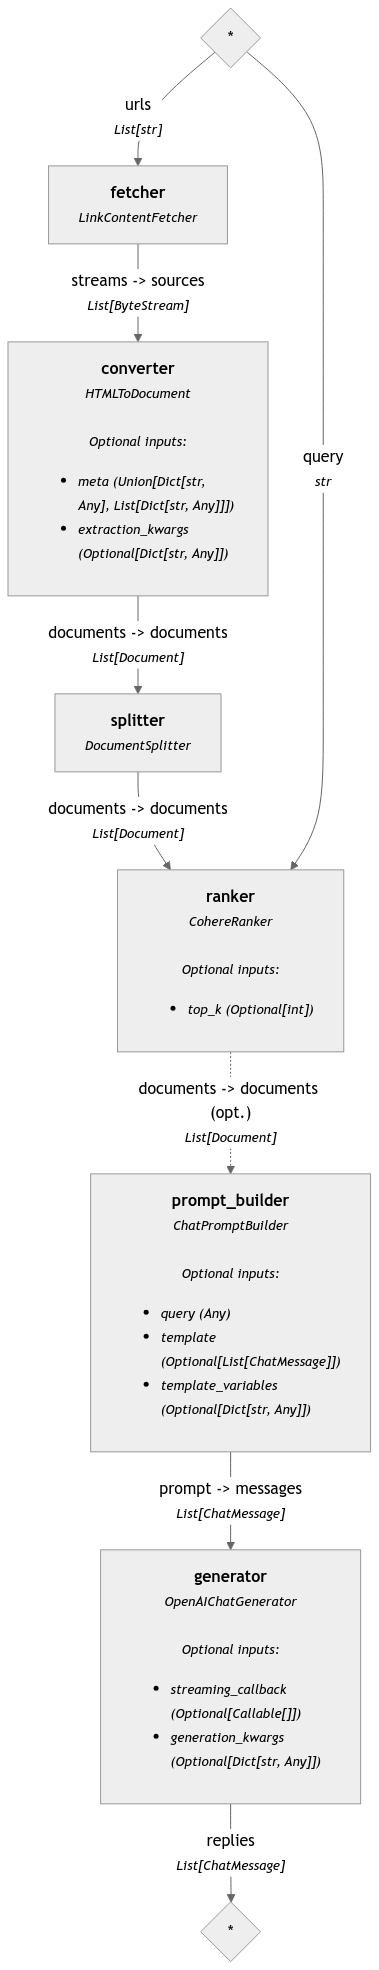

In [10]:
pipeline.show()

In [11]:
## Add parameters
for query in queries:
  result = pipeline.run(data={"fetcher": {"urls": urls}, "ranker": {"query": query, "top_k": 2},"prompt_builder": {"template_variables":{'query':query},"template": messages}})
  print(f'\n\n{query=}')
  # Print the LLM response
  print(result['generator']['replies'][0])
  print('-'*100)

INFO:haystack.core.pipeline.pipeline:Running component fetcher
INFO:haystack.core.pipeline.pipeline:Running component converter
INFO:haystack.core.pipeline.pipeline:Running component splitter
INFO:haystack.core.pipeline.pipeline:Running component ranker
INFO:haystack.core.pipeline.pipeline:Running component prompt_builder
INFO:haystack.core.pipeline.pipeline:Running component generator
INFO:haystack.core.pipeline.pipeline:Running component fetcher
INFO:haystack.core.pipeline.pipeline:Running component converter




query='What is the difference between metadata filtering and metadata enrichment?'
ChatMessage(content='No answer.', role=<ChatRole.ASSISTANT: 'assistant'>, name=None, meta={'model': 'gpt-4o-mini-2024-07-18', 'index': 0, 'finish_reason': 'stop', 'usage': {'completion_tokens': 4, 'prompt_tokens': 936, 'total_tokens': 940, 'completion_tokens_details': CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), 'prompt_tokens_details': PromptTokensDetails(audio_tokens=0, cached_tokens=0)}})
----------------------------------------------------------------------------------------------------


INFO:haystack.core.pipeline.pipeline:Running component splitter
INFO:haystack.core.pipeline.pipeline:Running component ranker
INFO:haystack.core.pipeline.pipeline:Running component prompt_builder
INFO:haystack.core.pipeline.pipeline:Running component generator
INFO:haystack.core.pipeline.pipeline:Running component fetcher
INFO:haystack.core.pipeline.pipeline:Running component converter




query='Which methods can I use to transform query for better retrieval?'
ChatMessage(content='You can use the methods of Query Decomposition and Query Expansion to transform queries for better retrieval. \n\n1. **Query Decomposition**: This involves breaking down a complex question into smaller, independent sub-questions that can be answered separately before reasoning about the final answer.\n\n2. **Query Expansion**: This technique involves enhancing keyword queries to improve recall, thereby retrieving more relevant contexts for a given query.\n\nUsed document links:\n- Query Decomposition: https://haystack.deepset.ai/blog/query-decomposition\n- Query Expansion: https://haystack.deepset.ai/blog/query-expansion', role=<ChatRole.ASSISTANT: 'assistant'>, name=None, meta={'model': 'gpt-4o-mini-2024-07-18', 'index': 0, 'finish_reason': 'stop', 'usage': {'completion_tokens': 120, 'prompt_tokens': 737, 'total_tokens': 857, 'completion_tokens_details': CompletionTokensDetails(accepted_pre

INFO:haystack.core.pipeline.pipeline:Running component splitter
INFO:haystack.core.pipeline.pipeline:Running component ranker
INFO:haystack.core.pipeline.pipeline:Running component prompt_builder
INFO:haystack.core.pipeline.pipeline:Running component generator
INFO:haystack.core.pipeline.pipeline:Running component fetcher
INFO:haystack.core.pipeline.pipeline:Running component converter




query='How can I use metadata to improve retrieval?'
ChatMessage(content='You can use metadata to improve retrieval by applying metadata filtering, which involves limiting the search space based on specific metadata attributes such as domain, source, date, or topic. This approach enhances the quality of retrieved documents by ensuring relevance, accuracy, and efficiency. By using metadata filtering, you can narrow down the information retrieved, guarantee accurate and trustworthy information, and eliminate irrelevant data, speeding up retrieval response times.\n\nURL: https://haystack.deepset.ai/blog/extracting-metadata-filter', role=<ChatRole.ASSISTANT: 'assistant'>, name=None, meta={'model': 'gpt-4o-mini-2024-07-18', 'index': 0, 'finish_reason': 'stop', 'usage': {'completion_tokens': 99, 'prompt_tokens': 922, 'total_tokens': 1021, 'completion_tokens_details': CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), 'pr

INFO:haystack.core.pipeline.pipeline:Running component splitter
INFO:haystack.core.pipeline.pipeline:Running component ranker
INFO:haystack.core.pipeline.pipeline:Running component prompt_builder
INFO:haystack.core.pipeline.pipeline:Running component generator




query="What's preprocessing?"
ChatMessage(content='No answer. \n\nUsed document links: \n1. https://haystack.deepset.ai/blog/extracting-metadata-filter\n2. https://haystack.deepset.ai/blog/query-decomposition', role=<ChatRole.ASSISTANT: 'assistant'>, name=None, meta={'model': 'gpt-4o-mini-2024-07-18', 'index': 0, 'finish_reason': 'stop', 'usage': {'completion_tokens': 42, 'prompt_tokens': 648, 'total_tokens': 690, 'completion_tokens_details': CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), 'prompt_tokens_details': PromptTokensDetails(audio_tokens=0, cached_tokens=0)}})
----------------------------------------------------------------------------------------------------
